# CNNを用いた手書きカタカナ文字認識（フレームワークなしで実装）

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.layer import Convolution, MaxPooling, ReLU, Affine, SoftmaxWithLoss, BatchNormalization, Dropout
from common.optimizer import RMSProp, Adagrad, Adadelta, Adam
from sklearn.model_selection import train_test_split
import pickle

## モデルの構築

In [2]:
# 畳込み層が4層(VGG)のモデルの実装

class VggConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':35, 'filter_size':3, 'pad':0, 'stride':1},
                 pool_param={'pool_size':2, 'pad':0, 'stride':2},
                 #dropout_ration = 0.25,
                 hidden_size=280, output_size=15, weight_init_std=0.01):
        """
        input_size : tuple, 入力の配列形状(チャンネル数、画像の高さ、画像の幅)
        conv_param : dict, 畳み込みの条件
        pool_param : dict, プーリングの条件
        hidden_size : int, 隠れ層のノード数
        output_size : int, 出力層のノード数
        weight_init_std ： float, 重みWを初期化する際に用いる標準偏差
        """
        # 畳込みの条件        
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        
        # プーリングの条件
        pool_size = pool_param['pool_size']
        pool_pad = pool_param['pad']
        pool_stride = pool_param['stride']
        
        # 各層の出力
        input_size = input_dim[1]
        conv1_output_size = (input_size + 2*filter_pad - filter_size) // filter_stride + 1 # 畳み込み1後のサイズ(H,W共通)
        conv2_output_size = (conv1_output_size + 2*filter_pad - filter_size) // filter_stride + 1 # 畳み込み2後のサイズ(H,W共通)
        pool1_output_size = (conv2_output_size + 2*pool_pad - pool_size) // pool_stride + 1 # プーリング1後のサイズ(H,W共通)
        
        conv3_output_size = (pool1_output_size + 2*filter_pad - filter_size) // filter_stride + 1 # 畳み込み3後のサイズ(H,W共通)
        conv4_output_size = (conv3_output_size + 2*filter_pad - filter_size) // filter_stride + 1 # 畳み込み4後のサイズ(H,W共通)
        pool2_output_size = (conv4_output_size + 2*pool_pad - pool_size) // pool_stride + 1 # プーリング2後のサイズ(H,W共通)
        
        pool_output_pixel = filter_num * 2 * pool2_output_size * pool2_output_size # プーリング2後のピクセル総数
        
        # 重みの初期化
        self.params = {}
        self.para = {}
        std = weight_init_std
        self.params['W1'] = std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b1'] = np.zeros(filter_num) #b1は畳み込みフィルターのバイアスになる
        
        self.params['gamma1'] = np.ones(filter_num)
        self.params['beta1'] = np.zeros(filter_num)
        
        self.params['W2'] = std * np.random.randn(filter_num, filter_num , filter_size, filter_size)
        self.params['b2'] = np.zeros(filter_num)
        
        self.params['gamma2'] = np.ones(filter_num)
        self.params['beta2'] = np.zeros(filter_num)
        
        self.params['W3'] = std * np.random.randn(filter_num*2, filter_num , filter_size, filter_size)
        self.params['b3'] = np.zeros(filter_num*2)
        
        self.params['gamma3'] = np.ones(filter_num*2)
        self.params['beta3'] = np.zeros(filter_num*2)
        
        self.params['W4'] = std * np.random.randn(filter_num*2, filter_num*2 , filter_size, filter_size)
        self.params['b4'] = np.zeros(filter_num*2)
        
        self.params['gamma4'] = np.ones(filter_num*2)
        self.params['beta4'] = np.zeros(filter_num*2)
        
        self.params['W5'] = std *  np.random.randn(pool_output_pixel, hidden_size)
        self.params['b5'] = np.zeros(hidden_size)
        
        self.params['gamma5'] = np.ones(hidden_size)
        self.params['beta5'] = np.zeros(hidden_size)
        
        self.params['W6'] = std *  np.random.randn(hidden_size, output_size)
        self.params['b6'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad']) 
        self.layers['BatchNorm1'] = BatchNormalization(self.params['gamma1'], self.params['beta1'])
        self.layers['ReLU1'] = ReLU()   
        self.layers['Conv2'] = Convolution(self.params['W2'], self.params['b2'],
                                           conv_param['stride'], conv_param['pad'])        
        self.layers['BatchNorm2'] = BatchNormalization(self.params['gamma2'], self.params['beta2'])
        self.layers['ReLU2'] = ReLU()
        self.layers['Pool1'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
        
        self.layers['Conv3'] = Convolution(self.params['W3'], self.params['b3'],
                                           conv_param['stride'], conv_param['pad']) 
        self.layers['BatchNorm3'] = BatchNormalization(self.params['gamma3'], self.params['beta3'])  
        self.layers['ReLU3'] = ReLU()    
        self.layers['Conv4'] = Convolution(self.params['W4'], self.params['b4'],
                                           conv_param['stride'], conv_param['pad'])        
        self.layers['BatchNorm4'] = BatchNormalization(self.params['gamma4'], self.params['beta4'])
        self.layers['ReLU4'] = ReLU()
        self.layers['Pool2'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
        
        self.layers['Affine1'] = Affine(self.params['W5'], self.params['b5'])       
        self.layers['BatchNorm5'] = BatchNormalization(self.params['gamma5'], self.params['beta5'])
        self.layers['ReLU5'] = ReLU()
    
        self.layers['Affine2'] = Affine(self.params['W6'], self.params['b6'])

        self.last_layer = SoftmaxWithLoss()

    
    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if  "BatchNorm1" in key or "BatchNorm2" in key or "BatchNorm3" in key or "BatchNorm4" in key or "BatchNorm5" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
                
        return x
    """
    def predict(self, x, train_flg=False):
        for layer in self.layers.values():
            x = layer.forward(x, train_flg)

        return x
    """

    def loss(self, x, t, train_flg=False):
        """
        損失関数
        x : 入力データ
        t : 教師データ
        """
        y = self.predict(x, train_flg)
        return self.last_layer.forward(y, t)
    
    """
    # CPUやサーバーの負担を減らすために、ミニバッチ処理で計算する際のメソッド（データの数を考えて割りきれる値に設定するように）
    
    def accuracy(self, x, t, batch_size=500):                                                            
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]
    """
    
    # データが多いとMemoryErrorとなるため上のミニバッチ処理で計算がよい（学習時かモデルのclassでミニバッチ処理での計算をコーディングする）
    def accuracy(self, x, t): # x：入力データ、t：正解ラベル（教師データ）、y：予測データ
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        y = self.predict(x, train_flg=False)
        y = np.argmax(y, axis=1)
        
        acc = np.sum(y==t)
        accuracy = acc/x.shape[0]
        
        return accuracy
    
    
    # 識別できていない画像を取得するメソッド
    def errors(self, x, t):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        y = self.predict(x, train_flg=False)
        y = np.argmax(y, axis=1)
        er = np.zeros(784)
        er = er.reshape(1, 28,28)
        
        for i in range(len(x)):
            if y[i] != t[i]:
                er = np.concatenate([er, x[i]])
        
        return er
    
    
    def gradient(self, x, t):
        """勾配を求める（誤差逆伝播法）
        Parameters
        ----------
        x : 入力データ
        t : 教師データ
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db        
        grads['gamma1'], grads['beta1'] = self.layers['BatchNorm1'].dgamma, self.layers['BatchNorm1'].dbeta        
        grads['W2'], grads['b2'] = self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['gamma2'], grads['beta2'] = self.layers['BatchNorm2'].dgamma, self.layers['BatchNorm2'].dbeta 
        
        grads['W3'], grads['b3'] = self.layers['Conv3'].dW, self.layers['Conv3'].db        
        grads['gamma3'], grads['beta3'] = self.layers['BatchNorm3'].dgamma, self.layers['BatchNorm3'].dbeta
        grads['W4'], grads['b4'] = self.layers['Conv4'].dW, self.layers['Conv4'].db
        grads['gamma4'], grads['beta4'] = self.layers['BatchNorm4'].dgamma, self.layers['BatchNorm4'].dbeta 
        
        grads['W5'], grads['b5'] = self.layers['Affine1'].dW, self.layers['Affine1'].db        
        grads['gamma5'], grads['beta5'] = self.layers['BatchNorm5'].dgamma, self.layers['BatchNorm5'].dbeta
        
        grads['W6'], grads['b6'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [3]:
# 描画を行う関数を作成
def draw(X):
    plt.figure(figsize=(16,8))
    pos = 1
    # 画像の枚数だけ描画処理を繰り返す
    for i in range(X.shape[0]):
        plt.subplot(4,8,pos)
        plt.imshow(X[i])
        plt.axis('off')
        plt.gray()
        pos += 1
    plt.show()


## データを読み込む

In [4]:
train_data = np.load("../1_data/train_data.npy")
train_label = np.load("../1_data/train_label.npy")
print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)


In [5]:
# 正規化
train_data = (train_data - train_data.min()) / train_data.max()
#train_data = train_data/255
train_data = train_data.astype('float32')

In [6]:
# 配列形式変更
train_data = train_data.reshape(-1, 28*28)
print("train_data.shape=", train_data.shape)

train_data.shape= (3000, 784)


## trainとtestに分割する

In [23]:
# なるべく訓練データを多くしたかったので、test_size=0.1とした
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, 
                                                                                        test_size=0.1, random_state=1234, 
                                                                                        shuffle=True
                                                                                       )

print(X_train.shape, X_test.shape)
print(y_train, y_test)

(2700, 784) (300, 784)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] [[0 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 1 ... 0 0 0]]


(2700, 28, 28) (300, 28, 28)
(2700, 15) (300, 15)


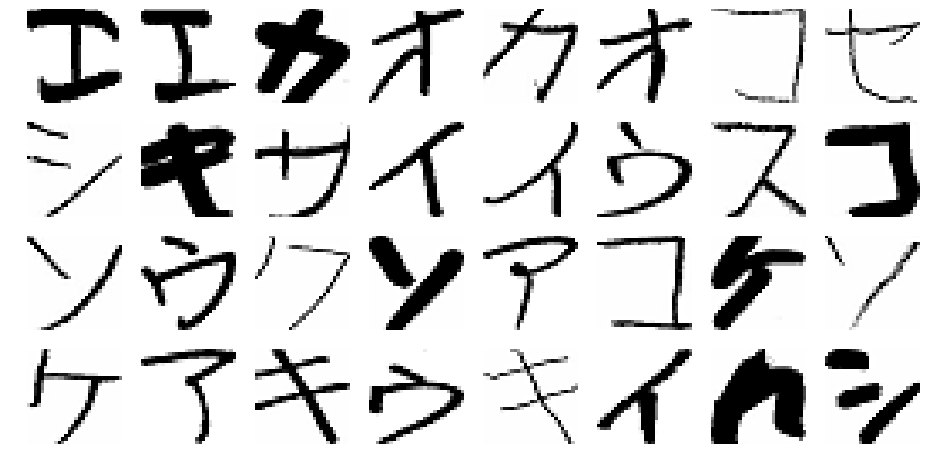

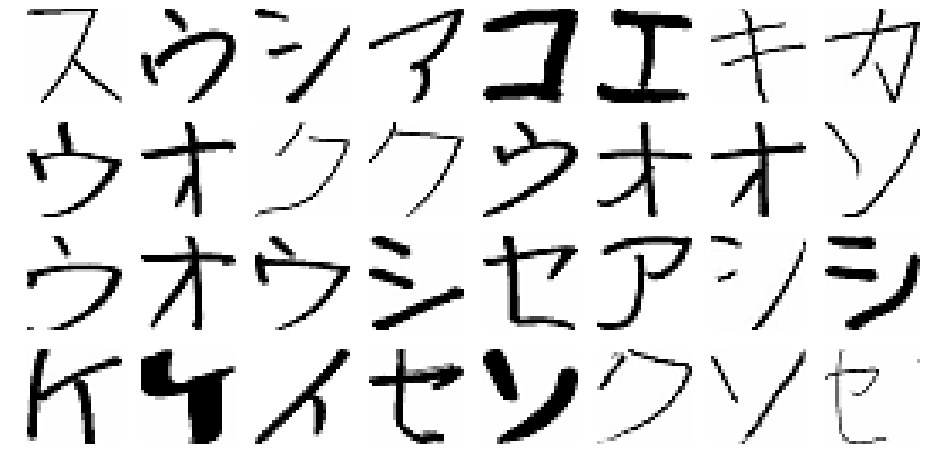

'\nt = y_train\nx = X_train.reshape(-1,28,28) # 配列形式の変形\n# 訓練データを表示\ndraw(x[0:32])\nx = x.reshape(-1,1,28,28) # 配列形式の変形\n'

In [24]:
x = X_train
t = y_train
test = X_test
test_labels = y_test

x = x.reshape(-1,28,28) # 配列形式の変形
test = test.reshape(-1, 28, 28)

print(x.shape, test.shape)
print(t.shape, test_labels.shape)
# 訓練データを表示
draw(x[0:32])
print()
# testデータを表示
draw(test[0:32])

(2700, 1, 28, 28)
(2700, 15)


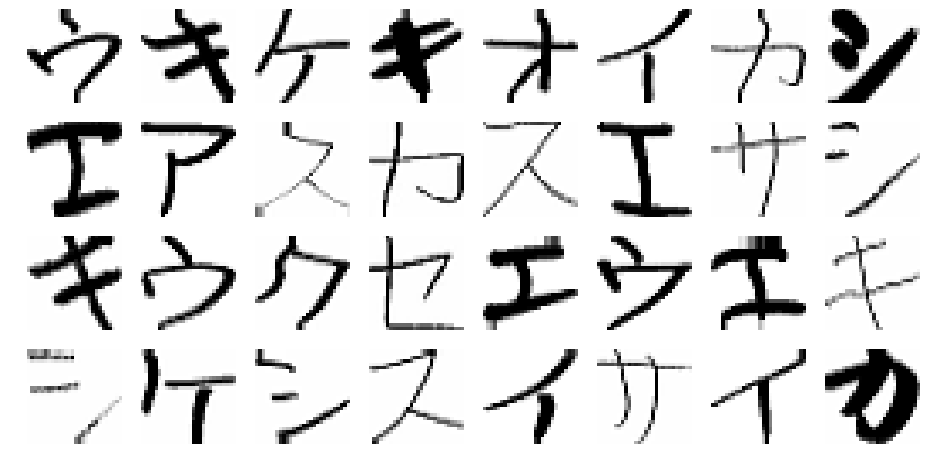

In [145]:
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator


x = x.reshape(-1,1,28,28) # 配列形式の変形
test = test.reshape(-1,1,28,28)

# ImageDataGeneratorのオブジェクト生成
datagen = ImageDataGenerator(
        rotation_range=15,
        #width_shift_range=0.1,
        height_shift_range=0.2,
        #shear_range=0.08,
        zoom_range= [0.9, 1.3]
        )

g = datagen.flow(
    x,t,batch_size=2700 )

X_batch, Y_batch = g.next()
print(X_batch.shape)
print(Y_batch.shape)

X_batch = X_batch.reshape(-1, 28, 28)

# データ拡張したデータを表示
draw(X_batch[0:32])
X_batch = X_batch.reshape(-1, 1, 28, 28)

In [165]:
# tとY_batch (xとX_batch)を結合させる

# 複数の配列ndarrayを結合する基本的な関数がnumpy.concatenate()。既存の軸（次元）に沿って結合する。
gen_t = np.concatenate([t, Y_batch])
gen_x = np.concatenate([x, X_batch])
print(gen_x.shape)
print(gen_t.shape)
print(len(gen_x))

print()
print(test.shape)
print(test_labels.shape)


(5400, 1, 28, 28)
(5400, 15)
5400

(300, 1, 28, 28)
(300, 15)


## 学習

In [166]:

epochs = 9
batch_size = 270 # 自分のパソコンだとbatch_size = 400でMemoryErrorとなる

# 最適化手法の選択（commonのoptimizer.pyで実装しているものが選択可能）
#optimizer = RMSProp(lr=0.01, rho=0.9) # 97.76%/97.46%(rho=0.9,fn=35,hs=280)
#optimizer = Adagrad(lr=0.01)
optimizer = Adam(lr=0.001, rho1=0.9, rho2=0.999) # 98%/98.08% (lr=0.001, rho1=0.9, rho2=0.999)
#optimizer = Adadelta(rho=0.95) # 98.33%/97.6%   (rho=0.95)

# 繰り返し回数
xsize = gen_x.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)

# CNNのオブジェクト生成
snet = VggConvNet(input_dim=(1, 28, 28), 
                 conv_param={'filter_num':35, 'filter_size':3, 'pad':0, 'stride':1},
                 pool_param={'pool_size':2, 'pad':0, 'stride':2},
                 hidden_size=280, output_size=15, weight_init_std=0.01)

# lossとaccuracyの計算結果を可視化するため結果を格納
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# ミニバッチ学習
for epoch in range(epochs):
    print("epoch=%s"%epoch)

    # シャッフル
    idx = np.arange(xsize)
    np.random.shuffle(idx)

    for it in range(iter_num):
        """
        ランダムなミニバッチを順番に取り出す
        """
        print("it=", it)
        mask = idx[batch_size*it : batch_size*(it+1)]

        # ミニバッチの生成
        x_train = gen_x[mask]
        t_train = gen_t[mask]

        # 勾配の計算 (誤差逆伝播法を用いる) 
        grads = snet.gradient(x_train, t_train)

        # 更新
        optimizer.update(snet.params, grads)

    ## 学習経過の記録
    
    # 予測
    # CPUへの負荷を軽減するため、ミニバッチ処理で行う(訓練データのみ)→計算がとても速くなる！
    # 自分のパソコンだとlossの計算ででMemoryErrorとなるため
    
    batch_s = batch_size
    data_size = len(gen_x)
    
    minibatch_num = np.ceil( data_size / batch_s).astype(int) # ミニバッチの個数
    
    li_loss = []
    li_accuracy = []
    li_num = []
    index = np.arange(data_size)
    
    for mn in range(minibatch_num):
        print(mn)
        mask_ = index[batch_size*mn:batch_s*(mn+1)]        
        data = gen_x[mask_]
        label = gen_t[mask_]
        loss  = snet.loss(data, label)
        accuracy  = snet.accuracy(data, label)
        print(loss, accuracy)
        
        li_loss.append(loss)
        li_accuracy.append(accuracy)
        li_num.append(len(data))

    tr_loss = np.dot(li_loss, li_num) / np.sum(li_num)
    tr_accuracy = np.dot(li_accuracy, li_num) / np.sum(li_num)
    
    print()
    
    # 訓練データにおけるloss
    #train_loss.append(snet.loss(gen_x, gen_t))
    train_loss.append(tr_loss)
    print("train_loss = %s"%train_loss[epoch])

    # テストデータにおけるloss
    test_loss.append(snet.loss(test, test_labels))
    print("test_loss = %s"%test_loss[epoch])

    # 訓練データにて精度を確認
    #train_accuracy.append(snet.accuracy(gen_x, gen_t))
    train_accuracy.append(tr_accuracy)
    print("train_accuracy = %s"%train_accuracy[epoch])
    
    # print("calculating test_accuracy")
    # テストデータにて精度を算出
    test_accuracy.append(snet.accuracy(test, test_labels))
    print("test_accuracy = %s"%test_accuracy[epoch])
    print()

epoch=0
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
it= 10
it= 11
it= 12
it= 13
it= 14
it= 15
it= 16
it= 17
it= 18
it= 19
0
0.8360464595934758 0.8222222222222222
1
0.7737948545487896 0.8296296296296296
2
0.8130230172968672 0.8333333333333334
3
0.7755006908733909 0.8185185185185185
4
0.8165330567643434 0.8444444444444444
5
0.865865208188528 0.8185185185185185
6
0.701369801949816 0.8962962962962963
7
0.7991165102015869 0.8407407407407408
8
0.7818817191618591 0.8444444444444444
9
0.8146136627874985 0.8629629629629629
10
0.8449701504317495 0.825925925925926
11
0.8546983820967073 0.8333333333333334
12
0.8961410887042577 0.7962962962962963
13
0.9289175540538603 0.7925925925925926
14
0.8702806107427088 0.8444444444444444
15
0.9019013878939534 0.7777777777777778
16
0.8868602396300137 0.7925925925925926
17
0.8971752474267031 0.8037037037037037
18
0.8821962068512265 0.7814814814814814
19
0.8623940693475818 0.8185185185185185

train_loss = 0.8401639959272459
test_loss = 0.81418484

test_loss = 0.09856712441876768
train_accuracy = 1.0
test_accuracy = 0.9733333333333334



(8, 28, 28)


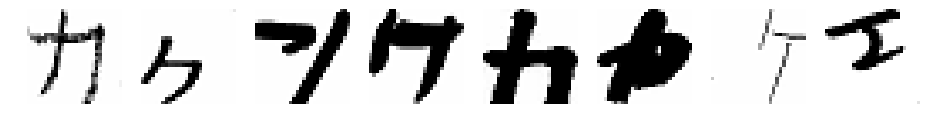

'\na = np.array([1, 2, 3])\nb = np.array([1, 4, 3])\nc = np.array([1, 2, 3])\n\nfor i in range(len(c)):\n    if a[i] != b[i]:\n        print(c[i])\n        #new_err = np.concatenate([er, x[i]])\n'

In [167]:
# 識別できていない画像を表示

err = snet.errors(test, test_labels)
err = np.delete(err, 0, 0) # 最初に表示される画像はerrorsメソッドで配列を作る際に自ら作ったモノなのでここで削除
print(err.shape)
draw(err)

# VggConvNet()でのerrorsメソッドの挙動の確認
"""
a = np.array([1, 2, 3])
b = np.array([1, 4, 3])
c = np.array([1, 2, 3])

for i in range(len(c)):
    if a[i] != b[i]:
        print(c[i])
        #new_err = np.concatenate([er, x[i]])
"""                       

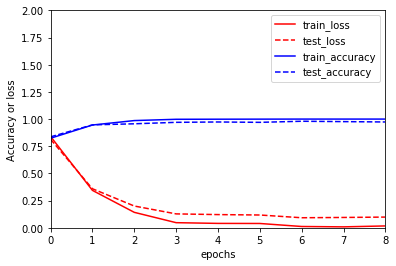

epoch = 6
train_accuracy = 1.0

epoch = 6
test_accuracy = 0.98


In [168]:
# lossとaccuracyのグラフ化

df_log = pd.DataFrame({"train_loss":train_loss,
             "test_loss":test_loss,
             "train_accuracy":train_accuracy,
             "test_accuracy":test_accuracy})

df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
plt.ylim([0,2])
plt.ylabel("Accuracy or loss")
plt.xlabel("epochs")
plt.show()

# 最高精度のエポックと正解率を表示
print("epoch = %s"%np.argmax(train_accuracy))
print("train_accuracy = %s"%max(train_accuracy))
print()
print("epoch = %s"%np.argmax(test_accuracy))
print("test_accuracy = %s"%max(test_accuracy))
#print("test_accuracy = %s"%test_accuracy[epoch])

## 学習済みモデルの出力

In [13]:
# 学習済みモデルをそのまま保存する際のプログラム（大きなデータとなってしまう）

#with open("katakana_model.pickle", "wb") as f:
    #pickle.dump(snet, f)

In [161]:
# 学習済みモデルのパラメータだけを保存する際のプログラム（小さなデータで済む）

param = snet.params # 学習済みモデルのパラメータをparamに代入

#for i in param:
    #print(i)

# bnpに学習済みモデルの移動平均、移動分散を格納
bnp = {}
bnp['moving_mean1'] = snet.layers['BatchNorm1'].moving_mean
bnp['moving_var1'] = snet.layers['BatchNorm1'].moving_var
bnp['moving_mean2'] = snet.layers['BatchNorm2'].moving_mean
bnp['moving_var2'] = snet.layers['BatchNorm2'].moving_var
bnp['moving_mean3'] = snet.layers['BatchNorm3'].moving_mean
bnp['moving_var3'] = snet.layers['BatchNorm3'].moving_var
bnp['moving_mean4'] = snet.layers['BatchNorm4'].moving_mean
bnp['moving_var4'] = snet.layers['BatchNorm4'].moving_var
bnp['moving_mean5'] = snet.layers['BatchNorm5'].moving_mean
bnp['moving_var5'] = snet.layers['BatchNorm5'].moving_var

# bnpに格納されているかの確認
#for i in bnp:
    #print(i)

print()

# bnpをparamに結合
param.update(bnp)
for i in param:
    print(i)

# 学習済みモデルのパラメータだけを保存    
with open("katakana_model.pickle", "wb") as f:
    pickle.dump(param, f)


W1
b1
gamma1
beta1
W2
b2
gamma2
beta2
W3
b3
gamma3
beta3
W4
b4
gamma4
beta4
W5
b5
gamma5
beta5
W6
b6
moving_mean1
moving_var1
moving_mean2
moving_var2
moving_mean3
moving_var3
moving_mean4
moving_var4
moving_mean5
moving_var5
